In [1]:
print("meowmeow")

print("hello?")

print("hehehaha")

meowmeow
hello?
hehehaha


In [2]:
print("kaiyi test")

print("weeeeeee")
print("weyuwuye")

kaiyi test
weeeeeee
weyuwuye


In [3]:
import cv2 # Will be used for edge detection further on
import os 
import numpy as np  # For numerical operations
from PIL import Image, ImageEnhance  # For image loading and augmentation
import matplotlib.pyplot as plt  # For visualization
from sklearn.preprocessing import LabelEncoder  # For encoding labels
import random  # For random transformations


In [4]:
from PIL import Image, ImageEnhance, ImageFilter


# Set Parameters
target_size = (224, 224)  # Standard input size for CNN
rotation_prob = 0.4  # 40% chance of rotation
saturation_prob = 0.5  # 50% chance of saturation change
min_saturation = 0.7  # Min saturation level
max_saturation = 1.3  # Max saturation level
blur_prob = 0.5  # 50% chance of blur
noise_prob = 0.5  # 50% chance of noise
min_crop_size = (70, 70)  # Minimum size of crop to avoid cutting off too much
padding = 80  # Padding to avoid cutting off important parts of the image
border_threshold = 5 # For the black border threshold count

# To crop out the edges
def auto_crop(img, padding=5, min_crop_size=(70, 70)):
    """
    Crops the image to the largest contour found using Canny edge detection.
    Returns the original image if no valid contour is found.
    """
    if isinstance(img, Image.Image):
        img_cv = np.array(img)
    else:
        img_cv = img.copy()

    gray = cv2.cvtColor(img_cv, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, threshold1=50, threshold2=100)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if cv2.contourArea(c) > 300]  # slightly more relaxed

    if contours:
        # Use the largest contour
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        x = max(0, x - padding)
        y = max(0, y - padding)
        x_end = min(img.width, x + w + 2 * padding)
        y_end = min(img.height, y + h + 2 * padding)

        cropped = img.crop((x, y, x_end, y_end))
        
        # Only return cropped if it still has valid size
        if cropped.size[0] >= min_crop_size[0] and cropped.size[1] >= min_crop_size[1]:
            return cropped

    return img  # fallback: return original image if crop fails



# Function to resize image
def resize_image(img, target_size=(224, 224)):
    return img.resize(target_size, Image.LANCZOS)


# Function to apply random blur to an image
def apply_random_blur(img, prob=0.5):
    if random.random() < prob:
        radius = random.uniform(0.1, 2.0)  # Random blur radius
        return img.filter(ImageFilter.GaussianBlur(radius))
    return img  # No blur

# Function to add random noise to an image
def add_random_noise(img, prob=0.5):
    if random.random() < prob:
        img_array = np.array(img)
        noise = np.random.normal(0, 0.1, img_array.shape)  # Add Gaussian noise
        noisy_img_array = img_array + noise * 255  # Scale noise
        noisy_img_array = np.clip(noisy_img_array, 0, 255).astype(np.uint8)  # Ensure values are valid
        return Image.fromarray(noisy_img_array)
    return img  # No noise

# Function to adjust saturation
def adjust_saturation(img, min_factor=0.7, max_factor=1.3, prob=0.5):
    if random.random() < prob:
        factor = random.uniform(min_factor, max_factor)
        enhancer = ImageEnhance.Color(img)
        return enhancer.enhance(factor)
    return img  # No change


def rotate_image(img, max_angle=10, rotation_prob=0.4):
    """Random rotation with proper border handling"""
    if random.random() < rotation_prob:
        angle = random.uniform(-max_angle, max_angle)
        
        # Rotate on expanded canvas
        rotated = img.rotate(angle, expand=True, resample=Image.BILINEAR)
        
        # Convert to numpy array for border detection
        np_img = np.array(rotated)
        
        if np_img.ndim == 3:  # Color image
            # Find non-black pixels (any channel > threshold)
            non_black = np.any(np_img > border_threshold, axis=2)
        else:  # Grayscale
            non_black = np_img > border_threshold
            
        if np.any(non_black):
            # Get bounding box coordinates
            rows = np.any(non_black, axis=1)
            cols = np.any(non_black, axis=0)
            y_min, y_max = np.where(rows)[0][[0, -1]]
            x_min, x_max = np.where(cols)[0][[0, -1]]
            
            # Crop and convert back to PIL
            cropped = rotated.crop((x_min, y_min, x_max, y_max))
            return cropped.resize(target_size, Image.LANCZOS)
    
    # Return original if no rotation or if border removal failed
    return img.resize(target_size, Image.LANCZOS) if rotation_prob else img

# Function to adjust brightness
def adjust_brightness(img, min_factor=1.1, max_factor=1.5, prob=0.5):
    if random.random() < prob:
        factor = random.uniform(min_factor, max_factor)
        enhancer = ImageEnhance.Brightness(img)
        return enhancer.enhance(factor)
    return img  # No change





In [ ]:
################### I(ame) replaced this chunk of code with the code below to experiment (dont run this) #############################

train_folder = "Train"  # Change to your dataset path
train_images = []
train_labels = []

for img_file in os.listdir(train_folder):
    if img_file.endswith(".png"):
        img_path = os.path.join(train_folder, img_file)

        # Load image using PIL
        img = Image.open(img_path).convert("RGB")

        # Extract class label from filename
        class_label = int(img_file.split("__")[0])

        # Apply preprocessing
        img = rotate_image(img, max_angle=10, rotation_prob=rotation_prob)  # Selective Rotation
        img = auto_crop(img)  # Crop after rotation
        img = adjust_brightness(img, prob=0.5) # adjust the brightness of images if they are darkened
        img = adjust_saturation(img, min_factor=min_saturation, max_factor=max_saturation, prob=saturation_prob)  # Selective Saturation
        img = apply_random_blur(img, prob=blur_prob)  # Random image blurring
        img = add_random_noise(img, prob=noise_prob)  # Apply random noise to some images
        img = resize_image(img, target_size)  # Resize after all transformations
        
        
        # Convert image to NumPy array and normalize
        img = np.array(img) / 255.0  

        # Store processed image and label
        train_images.append(img)
        train_labels.append(class_label)

# Convert to NumPy arrays
X_train = np.array(train_images)
y_train = np.array(train_labels)
 
 


In [126]:
from collections import Counter

train_folder = "Train"
train_images = []
train_labels = []

# Define what we consider a "rare class"
rare_threshold = 150  
extra_copies = 2       # generated 2 extra augmented data for rare classes

# First, count how many samples each class has
all_labels = [int(f.split("__")[0]) for f in os.listdir(train_folder) if f.endswith(".png")]
class_counts = Counter(all_labels)
rare_classes = [cls for cls, count in class_counts.items() if count < rare_threshold]

print(f"Rare classes: {rare_classes}")

for img_file in os.listdir(train_folder):
    if not img_file.endswith(".png"):
        continue

    img_path = os.path.join(train_folder, img_file)
    class_label = int(img_file.split("__")[0])
    img = Image.open(img_path).convert("RGB")
    img = auto_crop(img)

    def process_and_store(img_obj):
        img_aug = img_obj.copy()

        # Apply augmentations
        if class_label in rare_classes:
            # Strong augmentations for rare classes
            img_aug = adjust_brightness(img_aug, prob=1.0)
            img_aug = adjust_saturation(img_aug, min_factor=0.6, max_factor=1.6, prob=1.0)
            img_aug = rotate_image(img_aug, max_angle=15, rotation_prob=1.0)
            img_aug = apply_random_blur(img_aug, prob=1.0)
            img_aug = add_random_noise(img_aug, prob=1.0)
        else:
            # Standard augmentations for non-rare
            img_aug = rotate_image(img_aug, max_angle=10, rotation_prob=rotation_prob)
            img_aug = adjust_brightness(img_aug, prob=0.5)
            img_aug = adjust_saturation(img_aug, min_factor=min_saturation, max_factor=max_saturation, prob=saturation_prob)
            img_aug = apply_random_blur(img_aug, prob=blur_prob)
            img_aug = add_random_noise(img_aug, prob=noise_prob)

        # Final steps
        img_aug = resize_image(img_aug, target_size)
        img_aug = np.array(img_aug) / 255.0
        train_images.append(img_aug)
        train_labels.append(class_label)

    # Always process the original once
    process_and_store(img)

    # Generate more copies for rare classes
    if class_label in rare_classes:
        for _ in range(extra_copies):
            process_and_store(img)

# Convert to NumPy arrays
X_train = np.array(train_images)
y_train = np.array(train_labels)


Rare classes: [11, 18, 9, 7, 23, 14, 20, 12, 1, 5, 10, 3, 13, 19]


Class 0: 208 samples
Class 1: 264 samples
Class 2: 292 samples
Class 3: 312 samples
Class 4: 205 samples
Class 5: 255 samples
Class 6: 161 samples
Class 7: 231 samples
Class 8: 154 samples
Class 9: 315 samples
Class 10: 408 samples
Class 11: 444 samples
Class 12: 417 samples
Class 13: 330 samples
Class 14: 417 samples
Class 15: 477 samples
Class 16: 169 samples
Class 17: 172 samples
Class 18: 183 samples
Class 19: 255 samples
Class 20: 180 samples
Class 21: 353 samples
Class 22: 179 samples
Class 23: 348 samples


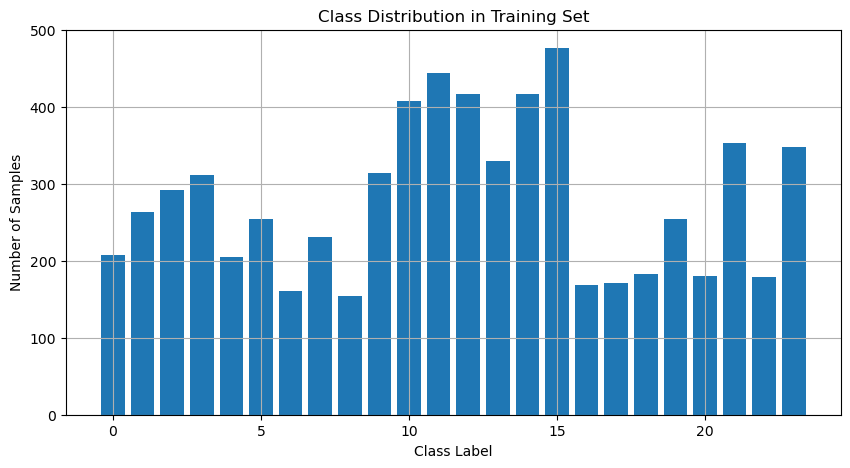

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Count samples per class
unique_classes, class_counts = np.unique(y_train, return_counts=True)

for label, count in zip(unique_classes, class_counts):
    print(f"Class {label}: {count} samples") # Print each class and respective samples

# Plotting the distribution of the classes
plt.figure(figsize=(10, 5))
plt.bar(unique_classes, class_counts)
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("After Balancing Class Distribution in Training Set")
plt.grid(True)
plt.show()


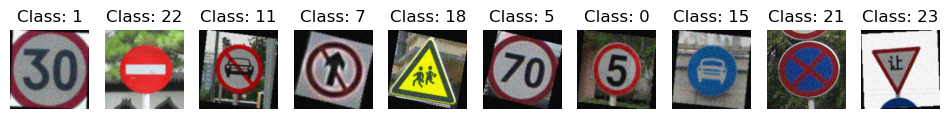

In [128]:
num_samples = 10  # Number of images to display
random_indices = random.sample(range(len(X_train)), num_samples)
#random_indices = np.size(random.sample(range(len(X_train)), 1))
#print(random_indices)
plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_train[idx])  # Show image
    plt.title(f"Class: {y_train[idx]}")
    plt.axis("off")

plt.show()


In [129]:
test_folder = "Test"  # Replace with actual test folder name
test_images = []
test_labels = []

for img_file in os.listdir(test_folder):
    if img_file.endswith(".png"):
        img_path = os.path.join(test_folder, img_file)
        img = Image.open(img_path).convert("RGB")

        class_label = int(img_file.split("__")[0])

        # Preprocessing: only clean, no augmentation
        img = auto_crop(img)  # Optional but keeps it consistent
        img = resize_image(img, target_size)
        img = np.array(img) / 255.0  # Normalize to [0, 1]

        test_images.append(img)
        test_labels.append(class_label)

X_test = np.array(test_images)
y_test = np.array(test_labels)

# this is my test data


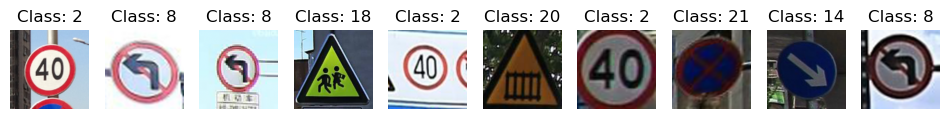

In [130]:
num_samples = 10
random_indices = random.sample(range(len(X_test)), num_samples)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"Class: {y_test[idx]}")
    plt.axis("off")

plt.show()


# CNN Modeling

## Loading Train and Test data

In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import WeightedRandomSampler

import matplotlib.pyplot as plt
import numpy

batch_size = 64

# Defining device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # mps if using mac gpu, else use cpu

# Convert numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## CNN Model

In [132]:
input_size = 224*224
output_size = len(np.unique(y_train)) #number of classes=24

class CNN(nn.Module):
    def __init__(self, input_size, n_features, output_size): #n_features = number of filters (feature maps)
        super(CNN, self).__init__()
        self.n_features = n_features
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_features, kernel_size=5) # input channel = 3 to allow for rgb image, update kernel size accordingly based on the input size
        self.conv2 = nn.Conv2d(n_features, n_features, kernel_size=5)
        self.fc1 = nn.Linear(n_features*53*53, 50)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(50, output_size) #adjust input and output variables accordingly

    def forward(self, x):
        x = self.conv1(x) 
        x = F.relu(x) #using relu activation fn
        x = F.max_pool2d(x, kernel_size=2) # to downside the output (IF NEEDED since we doubled it jn)
        x = self.conv2(x) 
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_features*53*53) #flattens the multi-dimensional output from the convolutional and pooling layers into a 1D vector to feed into fc layers
        x = self.fc1(x) #fully connected layers at the end
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1) #apply log soft max to the output
        return x



## Model Variables 

In [ ]:
# Variables for our model
# (TO BE ADJUSTED BASED ON HOW WE WANT TO TRAIN THE MODEL)
n_features = 32 #32 convolutional filters in first conv layer 
learning_rate = 0.0004 #reduced learning rate for more stable training
num_epochs = 20

In [ ]:
# Initialising the CNN model 
model = CNN(input_size=224, n_features = n_features, output_size=24)
model = model.to(device)

# use cross-entropy loss as loss function
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer (can change) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.0001)  #used Adam optimiser instead: converges faster and better for classification tasks


## Model Training

In [163]:
# TRAINING 

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

# Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

        # Calculate accuracy by calculating loss against predicted loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    #store losses and accuracy in train_losses and train_accuracies
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - " f"Train Loss: {avg_train_loss:.4f} - Train Acc: {train_accuracy:.2f}%")

Epoch [1/30] - Train Loss: 2.8649 - Train Acc: 16.41%
Epoch [2/30] - Train Loss: 2.0554 - Train Acc: 38.19%
Epoch [3/30] - Train Loss: 1.3373 - Train Acc: 59.98%
Epoch [4/30] - Train Loss: 0.9465 - Train Acc: 70.95%
Epoch [5/30] - Train Loss: 0.7546 - Train Acc: 76.28%
Epoch [6/30] - Train Loss: 0.6290 - Train Acc: 79.52%
Epoch [7/30] - Train Loss: 0.5350 - Train Acc: 82.08%
Epoch [8/30] - Train Loss: 0.4638 - Train Acc: 84.66%
Epoch [9/30] - Train Loss: 0.4319 - Train Acc: 85.15%
Epoch [10/30] - Train Loss: 0.3967 - Train Acc: 86.36%
Epoch [11/30] - Train Loss: 0.3558 - Train Acc: 87.28%
Epoch [12/30] - Train Loss: 0.3261 - Train Acc: 88.08%
Epoch [13/30] - Train Loss: 0.3166 - Train Acc: 88.71%
Epoch [14/30] - Train Loss: 0.2875 - Train Acc: 89.43%
Epoch [15/30] - Train Loss: 0.3191 - Train Acc: 88.91%
Epoch [16/30] - Train Loss: 0.3147 - Train Acc: 89.00%
Epoch [17/30] - Train Loss: 0.2592 - Train Acc: 90.64%
Epoch [18/30] - Train Loss: 0.2499 - Train Acc: 91.26%
Epoch [19/30] - Tra

## Plotting Train Loss and Train Accuracy

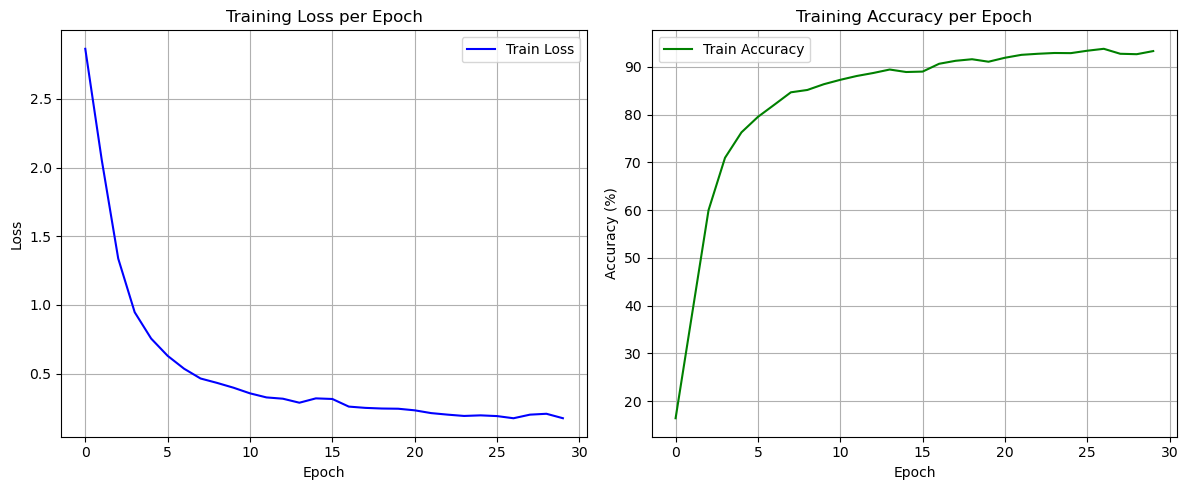

In [164]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", color="blue")
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", color="green")
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## Model Testing 

### Model Evaluation: Confusion Matrix


Test Loss: 1.9808
Test Accuracy: 69.38%


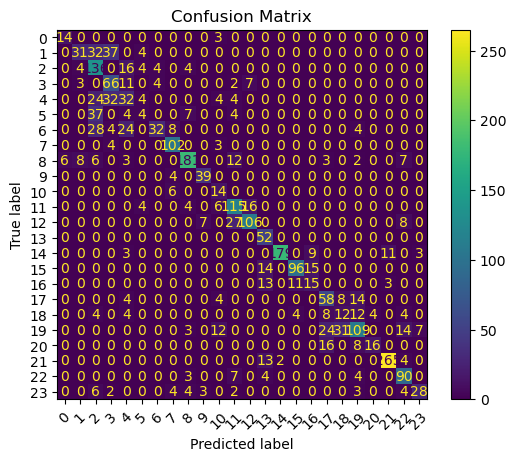

              precision    recall  f1-score   support

           0      0.700     0.824     0.757        17
           1      0.674     0.298     0.413       104
           2      0.498     0.810     0.617       168
           3      0.455     0.710     0.555        93
           4      0.317     0.320     0.318       100
           5      0.200     0.071     0.105        56
           6      0.800     0.320     0.457       100
           7      0.823     0.936     0.876       109
           8      0.879     0.794     0.834       228
           9      0.796     0.907     0.848        43
          10      0.304     0.700     0.424        20
          11      0.665     0.793     0.723       145
          12      0.822     0.716     0.765       148
          13      0.542     1.000     0.703        52
          14      0.989     0.873     0.927       205
          15      0.865     0.768     0.814       125
          16      0.385     0.357     0.370        42
          17      0.532    

In [165]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_true = []
y_pred = []

model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Final metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, digits=3))
